In [1]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [2]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_data = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [3]:
kf = KFold(n_splits=5)
kfolds_data = kf.split(train_data_raw)

partition = 1
for train_index, test_index in kfolds_data:
    train = pd.DataFrame(train_data_raw.values[train_index])
    train.columns = train_data_raw.columns

    test = pd.DataFrame(train_data_raw.values[test_index])
    test.columns = train_data_raw.columns
    
    train.to_csv(f'/kaggle/working/train_partition_{partition}.csv')
    test.to_csv(f'/kaggle/working/test_partition_{partition}.csv')
    
    partition +=1

In [4]:
train = pd.read_csv('/kaggle/working/train_partition_1.csv').iloc[:,1:]
test = pd.read_csv('/kaggle/working/test_partition_1.csv').iloc[:,1:]

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

essay =  train['full_text'][0]
longest_essay_length = train['full_text'].apply(len).max()

def tokenize(essays):
    return [
            tokenizer.encode(
            x,
            padding='max_length',
            max_length=longest_essay_length,
            truncation=True,
            add_special_tokens= False, #if treue [CLS] and [SEP] get added to each tokenizing.
            ) for x in train['full_text']]

encoded_essays = tokenize(train['full_text'])
#tokenizer.decode(essay_word_indices)

encoded_essays = tf.convert_to_tensor(encoded_essays)
#encoded_score = tf.convert_to_tensor((train['cohesion'] > 3).astype(int))

cohesion_normalized = (train['cohesion'] - train['cohesion'].mean()) / train['cohesion'].std()
syntax_normalized = (train['syntax'] - train['syntax'].mean()) / train['syntax'].std()
vocabulary_normalized = (train['vocabulary'] - train['vocabulary'].mean()) / train['vocabulary'].std()
phraseology_normalized = (train['phraseology'] - train['phraseology'].mean()) / train['phraseology'].std()
grammar_normalized = (train['grammar'] - train['grammar'].mean()) / train['grammar'].std()
conventions_normalized = (train['conventions'] - train['conventions'].mean()) / train['conventions'].std()

encoded_cohesion_score = tf.convert_to_tensor(cohesion_normalized)
encoded_syntax_score = tf.convert_to_tensor(syntax_normalized)
encoded_vocabulary_score = tf.convert_to_tensor(vocabulary_normalized)
encoded_phraseology_score = tf.convert_to_tensor(phraseology_normalized)
encoded_grammar_score = tf.convert_to_tensor(grammar_normalized)
encoded_conventions_score = tf.convert_to_tensor(conventions_normalized)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

2022-11-06 03:21:46.610968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:21:46.707250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:21:46.708338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 03:21:46.711168: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3CDCFB2C7F25,I believe that doing nothing is accomplishing ...,4.0,3.0,3.5,3.0,3.0,4.0
1,3CDD56FF3477,"Today, at school, most people are required by ...",5.0,3.5,4.0,3.5,3.0,4.0
2,3CED6DDF77BE,School districts should not offer programes th...,4.5,3.5,4.5,4.5,3.5,4.0
3,3D29C845934D,It has been said that a positive attitude is t...,4.0,4.5,4.0,4.0,4.5,4.5
4,3D3C80EF2AAA,"""It has been said that first impressions are a...",3.0,2.5,3.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...
3123,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3124,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3125,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3126,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [7]:
vocab_size_train =tokenizer.vocab_size + 2
embedding_dim = 512*3
tokenizer.vocab_size

#model
essay_input = keras.Input(shape=(longest_essay_length,))
embedding = layers.Embedding(vocab_size_train, embedding_dim, name="embedding")(essay_input)

conv_x =  layers.Conv1D( filters=512, kernel_size=3, padding='same', activation='relu')(embedding)
conv_x =  layers.Conv1D( filters=512, kernel_size=3, padding='same', activation='relu')(embedding)
conv_x =  layers.Dropout(rate=0.5)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

conv_x =  layers.Conv1D( filters=512, kernel_size=3, padding='same', activation='relu')(conv_x)
conv_x =  layers.Dropout(rate=0.5)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

conv_x =  layers.Conv1D( filters=512, kernel_size=3, padding='same', activation='relu')(conv_x)
conv_x =  layers.Dropout(rate=0.5)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

#max_pooling_x = layers.MaxPooling1D()(conv_x)

average_pooling_x = layers.GlobalAveragePooling1D()(max_pooling_x)

dense_x = layers.Dense(512, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.5)(dense_x)

dense_x = layers.Dense(512, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.5)(dense_x)


cohesion_prediction = layers.Dense(1, activation=None, name='cohesion_prediction')(dense_x)
syntax_prediction = layers.Dense(1, activation=None, name='syntax_prediction')(dense_x)
vocabulary_prediction = layers.Dense(1, activation=None, name='vocabulary_prediction')(dense_x)
phraseology_prediction = layers.Dense(1, activation=None, name='phraseology_prediction')(dense_x)
grammar_prediction = layers.Dense(1, activation=None, name='grammar_prediction')(dense_x)
conventions_prediction = layers.Dense(1, activation=None, name='conventions_prediction')(dense_x)

grader = keras.Model(
    inputs=[essay_input],
    outputs=[
        cohesion_prediction, 
        syntax_prediction,
        vocabulary_prediction,
        phraseology_prediction,
        grammar_prediction,
        conventions_prediction
    ],
    )

grader.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6044)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6044, 1536)   44540928    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6044, 512)    2359808     embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6044, 512)    0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
grader.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )])

hist = grader.fit(
    x=encoded_essays,
    y={
     'cohesion_prediction': encoded_cohesion_score, 
     'syntax_prediction': encoded_syntax_score,
     'vocabulary_prediction': encoded_vocabulary_score,
     'phraseology_prediction': encoded_phraseology_score,
     'grammar_prediction': encoded_grammar_score,
     'conventions_prediction': encoded_conventions_score
        
    },
    
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1, 
    epochs=20)

2022-11-06 03:22:11.514499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-06 03:22:13.963467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


44/44 [==============================] - 73s 1s/step - loss: 4.8053 - cohesion_prediction_loss: 0.8118 - syntax_prediction_loss: 0.7768 - vocabulary_prediction_loss: 0.8018 - phraseology_prediction_loss: 0.8123 - grammar_prediction_loss: 0.8030 - conventions_prediction_loss: 0.7996 - cohesion_prediction_root_mean_squared_error: 1.0131 - syntax_prediction_root_mean_squared_error: 1.0125 - vocabulary_prediction_root_mean_squared_error: 1.0179 - phraseology_prediction_root_mean_squared_error: 1.0188 - grammar_prediction_root_mean_squared_error: 1.0126 - conventions_prediction_root_mean_squared_error: 1.0241 - val_loss: 4.6331 - val_cohesion_prediction_loss: 0.7832 - val_syntax_prediction_loss: 0.7294 - val_vocabulary_prediction_loss: 0.7738 - val_phraseology_prediction_loss: 0.7922 - val_grammar_prediction_loss: 0.7847 - val_conventions_prediction_loss: 0.7698 - val_cohesion_prediction_root_mean_squared_error: 0.9747 - val_syntax_prediction_root_mean_squared_error: 0.9604 - val_vocabulary

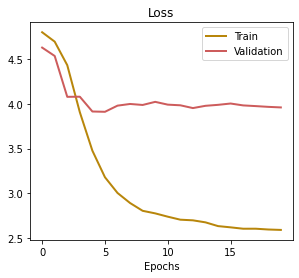

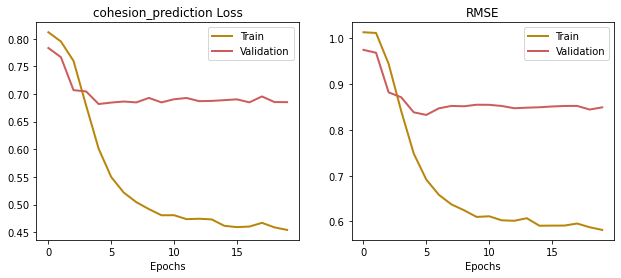

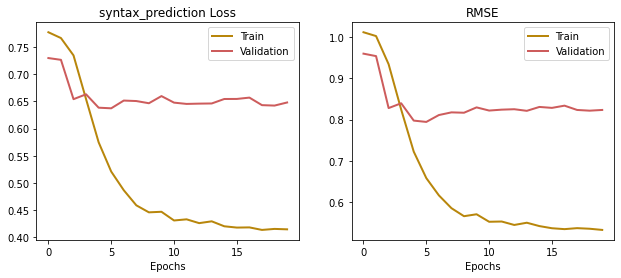

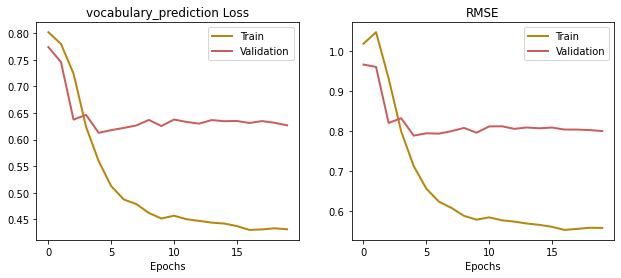

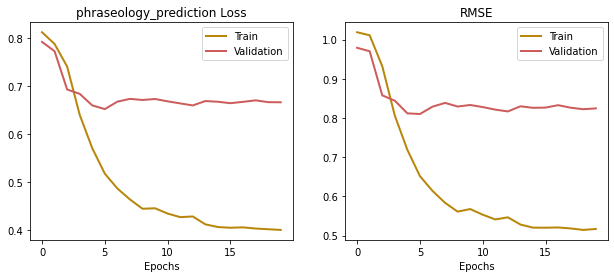

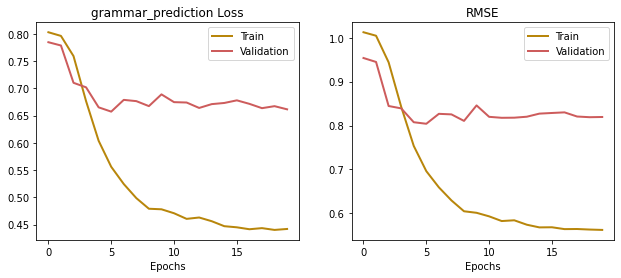

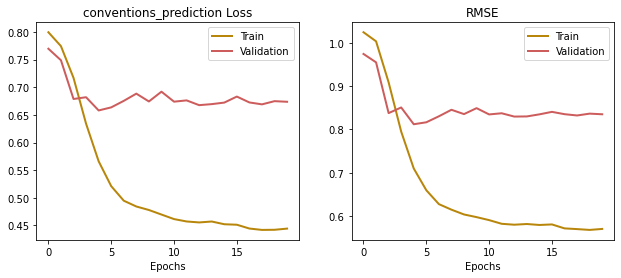

In [9]:
# grab history
history = hist.history


outputs = [ 'cohesion_prediction', 'syntax_prediction', 'vocabulary_prediction', 'phraseology_prediction', 'grammar_prediction', 'conventions_prediction' ]

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');
    

for output in outputs:
    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history[f'{output}_loss'], lw=2, color='darkgoldenrod')
    plt.plot(history[f'val_{output}_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title(f'{output} Loss');

    # plot accuracy for train and validation
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history[f'{output}_root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history[f'val_{output}_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.7,0.8)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('RMSE');
